In [ ]:
!pip install gdown
!gdown --fuzzy "https://drive.google.com/file/d/1KHEaqAGw_6ryBIcPIJwUDUkqEPJGJizi/view?usp=sharing"
!unzip *.zip -d dataset

Downloading...
From: https://drive.google.com/uc?id=1KHEaqAGw_6ryBIcPIJwUDUkqEPJGJizi
To: /content/data.zip
100% 8.42M/8.42M [00:00<00:00, 40.8MB/s]
Archive:  data.zip
   creating: dataset/data/
   creating: dataset/data/data/
   creating: dataset/data/data/foods/
   creating: dataset/data/data/foods/train/
   creating: dataset/data/data/foods/train/Banh-cuon/
  inflating: dataset/data/data/foods/train/Banh-cuon/Banh-cuon-1.webp  
  inflating: dataset/data/data/foods/train/Banh-cuon/Banh-cuon-2.jpg  
  inflating: dataset/data/data/foods/train/Banh-cuon/Banh-cuon-3.jpg  
  inflating: dataset/data/data/foods/train/Banh-cuon/Banh-cuon-4.jpg  
   creating: dataset/data/data/foods/train/Banh-mi/
  inflating: dataset/data/data/foods/train/Banh-mi/Banh-mi-1.webp  
  inflating: dataset/data/data/foods/train/Banh-mi/Banh-mi-2.jpg  
  inflating: dataset/data/data/foods/train/Banh-mi/Banh-mi-3.webp  
  inflating: dataset/data/data/foods/train/Banh-mi/Banh-mi-4.webp  
   creating: dataset/data/dat

In [ ]:
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models

# Định nghĩa các phép biến đổi cho hình ảnh
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Tải dữ liệu huấn luyện và kiểm tra
data_dir = '/content/dataset/data/data/foods'
image_datasets = {x: datasets.ImageFolder(os.path.join(
    data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(
    image_datasets[x], batch_size=4, shuffle=True) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Sử dụng GPU nếu có thể
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Định nghĩa mô hình
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

# Định nghĩa hàm mất mát và thuật toán tối ưu
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Huấn luyện mô hình
num_epochs = 4
for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # Mỗi epoch có hai giai đoạn: huấn luyện và kiểm tra
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        # Duyệt qua dữ liệu
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Xóa gradient của các tham số
            optimizer.zero_grad()

            # Tính toán đầu ra và hàm mất mát
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Cập nhật tham số nếu đang trong giai đoạn huấn luyện
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Thống kê kết quả
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print()

# Lưu mô hình lại dưới dạng tệp .pth
torch.save(model.state_dict(), 'food_classifier.pth')


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 201MB/s]


Epoch 0/3
----------
train Loss: 1.8136 Acc: 0.1500
val Loss: 1.3601 Acc: 0.6000

Epoch 1/3
----------
train Loss: 1.5552 Acc: 0.2000
val Loss: 1.2915 Acc: 0.4500

Epoch 2/3
----------
train Loss: 1.3972 Acc: 0.4000
val Loss: 1.1811 Acc: 0.5500

Epoch 3/3
----------
train Loss: 1.1672 Acc: 0.6000
val Loss: 1.0620 Acc: 0.6000



In [ ]:
from google.colab import files
from IPython.display import display
import ipywidgets as widgets
from PIL import Image
import torch
from torchvision import transforms, models
from torch import nn

# ---- Load model ----
model = models.resnet18()
num_ftrs = model.fc.in_features

state_dict = torch.load("food_classifier.pth", map_location="cpu")
num_classes = state_dict['fc.weight'].shape[0]
model.fc = nn.Linear(num_ftrs, num_classes)
model.load_state_dict(state_dict)
model.eval()

# ---- Transform ----
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

class_names = ['Bánh cuốn', 'Bánh mì', 'Bánh xèo', 'Bún bò huế', 'Bún chả']


# ---- Predict function ----
def import_and_predict(_):
    uploaded = files.upload()
    if len(uploaded) == 0:
        return

    file_name = list(uploaded.keys())[0]

    img = Image.open(file_name).convert("RGB")
    display(img)

    img_t = transform(img).unsqueeze(0)

    with torch.no_grad():
        output = model(img_t)
        pred = output.argmax(1).item()

    print("👉 Predicted:", class_names[pred])

Saving Screenshot 2025-11-22 110308.png to Screenshot 2025-11-22 110308 (1).png


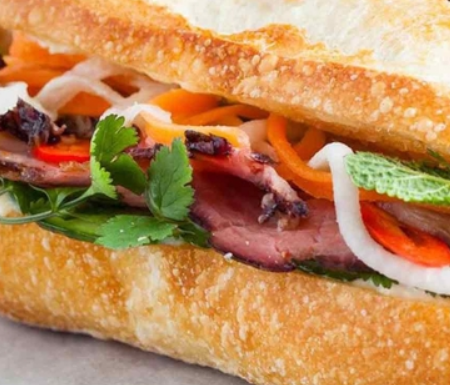

👉 Predicted: Bánh mì


In [ ]:
import_and_predict(_)


Saving Screenshot 2025-11-22 104558.png to Screenshot 2025-11-22 104558.png


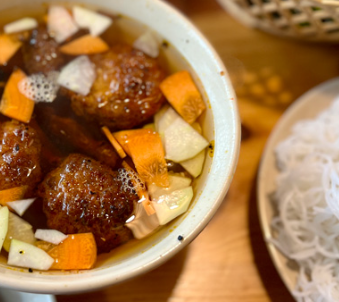

👉 Predicted: Bún chả


In [ ]:
import_and_predict(_)
